# Tema

Sa se creeze si antreneze o retea de tip convolutional pentru setul de date [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). Intrarea este RGB, de forma 32 x 32 x 3. Reteaua va avea urmatoarea arhitectura:

| Strat       | Numar filtre/neuroni | Dimensiune kernel |  Stride | Dim. harta de trasaturi |
| ------------|----------------------|-------------------|---------|-------------------------|
| Conv 1      |          32          |        3x3        |    1    |      30 x 30 x 32       |
| Conv 2      |          64          |        3x3        |    1    |      28 x 28 x 64       |
| Conv 3      |          128         |        3x3        |    1    |      26 x 26 x 128      |
| Pool 4      |          128         |         2         |    2    |      13 x 13 x 128      |
| Conv 5      |          256         |        3x3        |    1    |      11 x 11 x 256      |
| Conv 6      |          512         |        3x3        |    1    |       9 x  9 x 512      |
| Pool 7      |          512         |        3x3        |    3    |       3 x  3 x 512      |
| Conv 8      |          1024        |        3x3        |    1    |       1 x  1 x 1024     |
| Linear 9    |           -          |         -         |    -    |           100           |
| Linear 10   |           -          |         -         |    -    |            10           |

## Import de pachete

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import sys

# Verificare device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    print(f'Training on GPU: {torch.cuda.get_device_name(0)}')
    use_amp = True
else:
    print('Training on CPU')
    use_amp = False

print(f'PyTorch version: {torch.__version__}')

🚀 SUCCESS: Training on GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Using PyTorch version: 2.5.1+cu121  Device: cuda


In [2]:
# !pip install torch-summary
from torchsummary import summary

## Pregatire dataset, dataloader

In [3]:
batch_size = 64

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = datasets.CIFAR10('./data', 
                               train=True, 
                               download=True, 
                               transform=train_transform)

assert len(train_dataset) == 50000

validation_dataset = datasets.CIFAR10('./data', 
                                    train=False, 
                                    transform=test_transform)

assert len(validation_dataset) == 10000

# DataLoader cu pin_memory doar daca GPU
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=2 if device.type == 'cuda' else 0,
                                           pin_memory=(device.type == 'cuda'))

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False,
                                                num_workers=2 if device.type == 'cuda' else 0,
                                                pin_memory=(device.type == 'cuda'))

Files already downloaded and verified


In [4]:
for (X_train, y_train) in train_loader:
    print(f"X_train: {X_train.size()} type: {X_train.type()}")
    print(f"y_train: {y_train.size()} type: {y_train.type()}")
    break

X_train: torch.Size([64, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([64]) type: torch.LongTensor


In [5]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

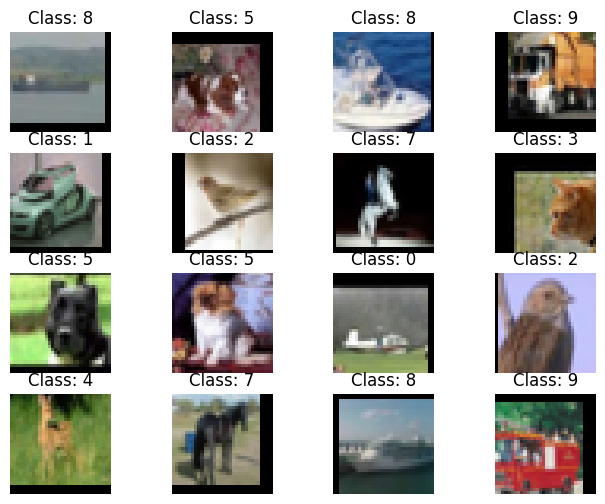

In [6]:
plt.figure(figsize=(8, 6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    img = X_train[i,:,:,:].numpy().reshape(3,32,32).transpose(1,2,0)
    img = img * np.array([0.2023, 0.1994, 0.2010]) + np.array([0.4914, 0.4822, 0.4465])
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title('Class: '+str(y_train[i].item()))

In [7]:
# TensorBoard not required for basic logging
# from torch.utils.tensorboard import SummaryWriter


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Functii utile: antrenare, validare

In [8]:
def train(model, epoch, log_interval=50):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        if use_amp:
            with torch.amp.autocast('cuda'):
                output = model(data)
                loss = criterion(output, target)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

In [9]:
def validate(model, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(validation_loader.dataset)
    acc = 100. * correct / len(validation_loader.dataset)
    
    print(f'\nValidation set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(validation_loader.dataset)} ({acc:.0f}%)\n')
    return acc

## Definire model

In [10]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.conv5 = nn.Conv2d(128, 256, 3)
        self.conv6 = nn.Conv2d(256, 512, 3)
        self.pool7 = nn.MaxPool2d(3, 3)
        
        self.conv8 = nn.Conv2d(512, 1024, 3)
        
        self.fc1 = nn.Linear(1024, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool4(x)
        
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool7(x)
        
        x = F.relu(self.conv8(x))
        
        x = x.view(-1, 1024)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

my_net = MyNet()

In [11]:
summary(my_net.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
            Conv2d-2           [-1, 64, 28, 28]          18,496
            Conv2d-3          [-1, 128, 26, 26]          73,856
         MaxPool2d-4          [-1, 128, 13, 13]               0
            Conv2d-5          [-1, 256, 11, 11]         295,168
            Conv2d-6            [-1, 512, 9, 9]       1,180,160
         MaxPool2d-7            [-1, 512, 3, 3]               0
            Conv2d-8           [-1, 1024, 1, 1]       4,719,616
            Linear-9                  [-1, 100]         102,500
           Linear-10                   [-1, 10]           1,010
Total params: 6,391,702
Trainable params: 6,391,702
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 2.02
Params size (MB): 24.38
Estima

## Antrenare si validare

In [12]:
my_net.to(device)
optimizer = torch.optim.SGD(my_net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# GradScaler doar daca GPU si AMP activ
if use_amp:
    scaler = torch.amp.GradScaler('cuda')
else:
    scaler = None

In [ ]:
epochs = 20

print(f"Start Training on {device}...")
for epoch in range(1, epochs + 1):
    t0 = time.time()
    train(my_net, epoch)
    acc = validate(my_net, epoch)
    print(f"Epoch Time: {time.time()-t0:.2f} seconds")

Start Training on cuda...
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.298035
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.304077
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.295502
Train Epoch: 1 [9600/50000 (19%)]	Loss: 2.297607
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.261841
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.239410
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.122375
Train Epoch: 1 [22400/50000 (45%)]	Loss: 1.974670
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.965065
Train Epoch: 1 [28800/50000 (58%)]	Loss: 1.839882
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.841774
Train Epoch: 1 [35200/50000 (70%)]	Loss: 1.764542
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.702309
Train Epoch: 1 [41600/50000 (83%)]	Loss: 1.665714
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.734711
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.818863

Validation set: Average loss: 1.6690, Accuracy: 3802/10000 (38%)

Epoch Time: 29.96 seconds
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.830345
Train Epoch: 2 [3200/50000 (6%)]	Loss: 1.6920

In [ ]:
# Plotare rezultate din TensorBoard (sau history daca am fi salvat)
# Aici doar exemplificam salvarea modelului

torch.save(my_net.state_dict(), 'cifar10_cnn.pth')
print("Model saved to cifar10_cnn.pth")

In [ ]:
# Vizualizare predictii pe setul de test
dataiter = iter(validation_loader)
images, labels = next(dataiter)
images = images.to(device)

output = my_net(images)
_, preds = torch.max(output, 1)

images = images.cpu()
fig = plt.figure(figsize=(12, 12))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    
    img = images[i].numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    color = 'green' if preds[i] == labels[i] else 'red'
    ax.set_title(f"{classes[preds[i]]} ({classes[labels[i]]})", color=color)